In [1]:
!pip install fastai --upgrade

     |████████████████████████████████| 194kB 16.8MB/s 
     |████████████████████████████████| 51kB 8.2MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [2]:
import fastai
fastai.__version__

'2.1.7'

In [3]:
# install the dependencies
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Change permissions
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

 99% 709M/714M [00:09<00:00, 105MB/s]
100% 714M/714M [00:09<00:00, 76.5MB/s]


In [7]:
from zipfile import ZipFile
file_name = 'lgg-mri-segmentation.zip'
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [8]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision.all import *
from fastai.callback.hook import *

In [9]:
save_path = 'saved_model'

In [10]:
get_mask_path = lambda x : x.parents[0] / (x.stem + '_mask' + x.suffix)

In [11]:
data_path = Path('/content/lgg-mri-segmentation/kaggle_3m')
smalldata_path = data_path / 'TCGA_CS_4941_19960909'

In [12]:
smalldata_path.ls()

(#46) [Path('/content/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_21_mask.tif'),Path('/content/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_9_mask.tif'),Path('/content/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10.tif'),Path('/content/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_17.tif'),Path('/content/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_14.tif'),Path('/content/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_5.tif'),Path('/content/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_8.tif'),Path('/content/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11_mask.tif'),Path('/content/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_8_mask.tif'),Path('/content/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960

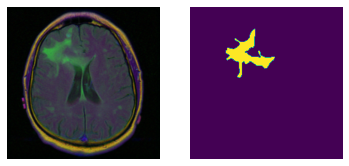

In [13]:
sample_imgfile_path = smalldata_path/'TCGA_CS_4941_19960909_15.tif'
img = Image.open(sample_imgfile_path)
sample_maskfile_path = get_mask_path(sample_imgfile_path)
mask = Image.open(sample_maskfile_path)
show_images((img, mask))

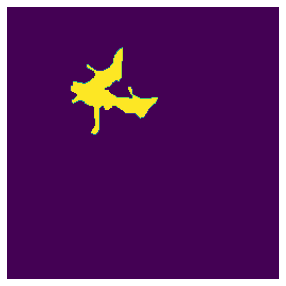

In [14]:
show_image(mask, alpha=1)

In [15]:
mask_t = cast(mask, TensorMask)
src_size = np.array(mask_t.shape)
src_size, mask_t.data

(array([256, 256]), TensorMask([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8))

In [16]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import gc
import humanize
import os
import GPUtil as GPU
import psutil

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7411 sha256=96fb6169d3a11585dc192c290049370704b44b8f3a6f8f4d5ac4931b6e28b58b
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil


In [17]:
GPUs = GPU.getGPUs()
gpu = GPUs[0]
# XXX: only one GPU on Colab and isn’t guaranteed
def printm():
 process = psutil.Process(os.getpid())
 gc.collect()
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 12.7 GB  | Proc size: 325.3 MB
GPU RAM Free: 15069MB | Used: 10MB | Util   0% | Total 15079MB


In [18]:
bs = 8
splitter = FuncSplitter(lambda posix_path: '_mask' in posix_path.name)
fnames = get_image_files(data_path)
images, masks = splitter(fnames)
images, masks = fnames[images], fnames[masks]
images, masks

((#3929) [Path('/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_6.tif'),Path('/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_22.tif'),Path('/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_17.tif'),Path('/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_8.tif'),Path('/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_18.tif'),Path('/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_13.tif'),Path('/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_11.tif'),Path('/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_25.tif'),Path('/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_16.tif'),Path('/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_2.tif')...]

In [19]:
codes = ['n', 'y']

In [20]:
tfms = [IntToFloatTensor(div_mask=255), Brightness(0.1, p=0.25), Zoom(max_zoom=1.1,p=0.25), Normalize.from_stats(*imagenet_stats)]

In [50]:
dls = SegmentationDataLoaders.from_label_func(data_path, images, get_mask_path, item_tfms=[Resize(src_size//2, method=ResizeMethod.Squish)], batch_tfms=tfms, valid_pct=0.2, codes=codes, seed=42, bs=8)

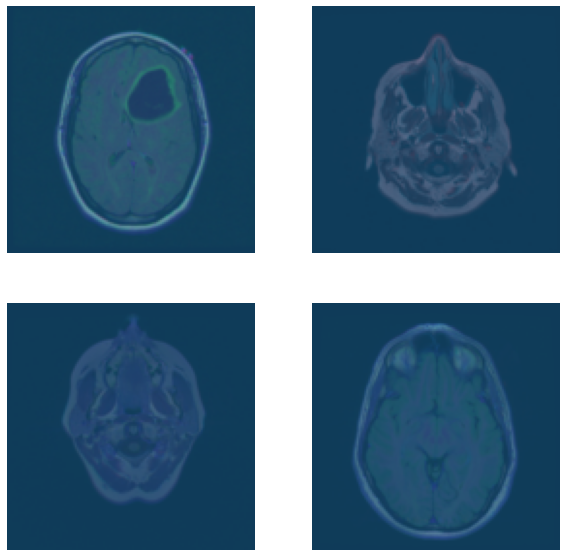

In [51]:
dls.show_batch(max_n=4, figsize=(10, 10))

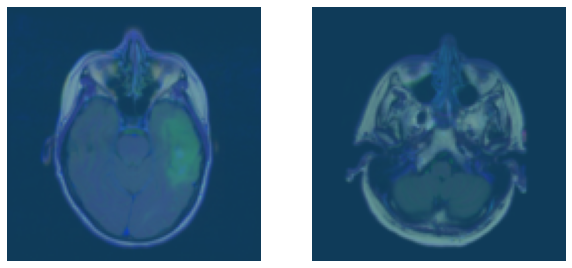

In [23]:
dls.valid.show_batch(max_n=2, figsize=(10, 10))

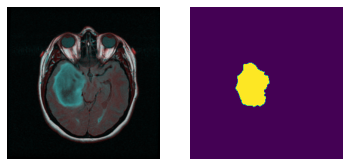

In [24]:
show_images(dls.train_ds[2])

In [25]:
t_mask = cast(dls.train_ds[2][1], TensorMask)
t_mask.argmax(dim=1)

TensorMask([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  98,  96,  90,
         89,  89,  89,  89,  89,  89,  89,  89,  89,  89,  88,  87,  87,  86,
         85,  84,  83,  82,  80,  79,  79,  79,  79,  79,  80,  80,  80,  80,
         80,  80,  79,  79,  79,  78,  78,  78,  77,  77,  76,  76,  76,  77,
         78,  78,  80,  80,  80,  81,  81,  82,  82,  82,  83,  83,  83,  84,
         84,  84,  85,  86,  86,  86,  86,  87,  87,  88,  89,  93,  95, 105,
        106,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

## Model

In [52]:
from fastai.vision.models import resnet34

learn = unet_learner(dls, resnet34, metrics=[Dice()])

SuggestedLRs(lr_min=0.0013182567432522773, lr_steep=9.999999747378752e-06)

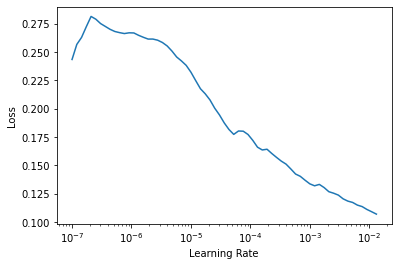

In [53]:
learn.lr_find()

In [54]:
lr = 1e-4

In [55]:
learn.fit_one_cycle(10, slice(lr)) #https://github.com/fastai/fastai/issues/3041

epoch,train_loss,valid_loss,dice,time
0,0.020379,0.014151,None,00:56


TypeError: ignored